# Language Models

This section implements two language models: a unigram and a bigram model. Their classes can be found in the in the 'ngram.py' file in the LanguageModels folder.

In [ ]:
from LanguageModels.NGramLM import NGramLM
from LanguageModels.UniformLM import UniformLM
from LanguageModels.InterpolatedLM import InterpolatedLM
from LanguageModels.AdjustedLaplaceLM import AdjustedLaplaceLM
from LanguageModels.LSTM_model import LSTM
import matplotlib.pyplot as plt
import numpy as np

In [9]:
%run /app/prepare_data.py english

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Adding  english to dict


# Preparing functions for evaluation

In [3]:
def inject_OOVs(data):
    """Inject OOV symbols for the first appearance of each word.
    This is done to discard words that are either not in the vocabulary of the language model or just not very frequent."""
    seen = set()
    result = []
    for word in data:
        if word in seen:
            result.append(word)
        else:
            result.append('OOV')
            seen.add(word)
    return result

def plot_top_probabilities(model, vocab, model_name, amount=10):
    """
    Plots the top probabilities of words in the language model.
    Args:
        model: The language model instance.
        vocab: The vocabulary of the model.
        how_many: Number of top probabilities to display (default: 10).
        model_name: Name of the model for better plot description.
    """
    # Calculate probabilities and sort
    probs = sorted([(word, model.probability(word)) for word in vocab], key=lambda x: x[1], reverse=True)[:amount]
    words, probabilities = zip(*probs)

    # plot
    plt.figure(figsize=(8, 6))
    plt.barh(words, probabilities, color='skyblue', edgecolor='black')
    plt.xlabel("Probability")
    plt.ylabel("Words")
    plt.title(f"Top {amount} Probabilities in {model_name}", fontsize=14)
    plt.grid(axis='x', linestyle='--', alpha=0.7)  # Add gridlines for clarity
    plt.gca().invert_yaxis()  # Reverse order for descending probabilities

    # Annotate probabilities
    for i, prob in enumerate(probabilities):
        plt.text(prob + 0.01, i, f"{prob:.3f}", va='center', fontsize=10)

    # Show the plot
    plt.tight_layout()
    plt.show()

# The unigram model

In [4]:
def unigram_injection(train, test):
    """
    Trains and evaluates a unigram language model with OOV handling.

    Args:
        train: Training data as a list of tokens.
        test: Test data as a list of tokens.
    """
    oov_train = inject_OOVs(train)
    oov_vocab = set(oov_train)
    oov_test = [word if word in oov_vocab else 'OOV' for word in test]

    # Models
    uniform_model = UniformLM(oov_vocab)
    unigram_model = NGramLM(oov_train, 1)

    # Perplexity
    perplexity_uniform = uniform_model.perplexity(oov_test)
    perplexity_unigram = unigram_model.perplexity(oov_test)

    # Results
    print(f"Uniform Model Perplexity: {round(perplexity_uniform, 3)}")
    print(f"Unigram Model Perplexity: {round(perplexity_unigram, 3)}")
    return unigram_model, oov_vocab, perplexity_uniform, perplexity_unigram

Unigram for english:
Uniform Model Perplexity: 30175.0
Unigram Model Perplexity: 719.921
Uniform Model Perplexity: 30175.0
Unigram Model Perplexity: 719.921


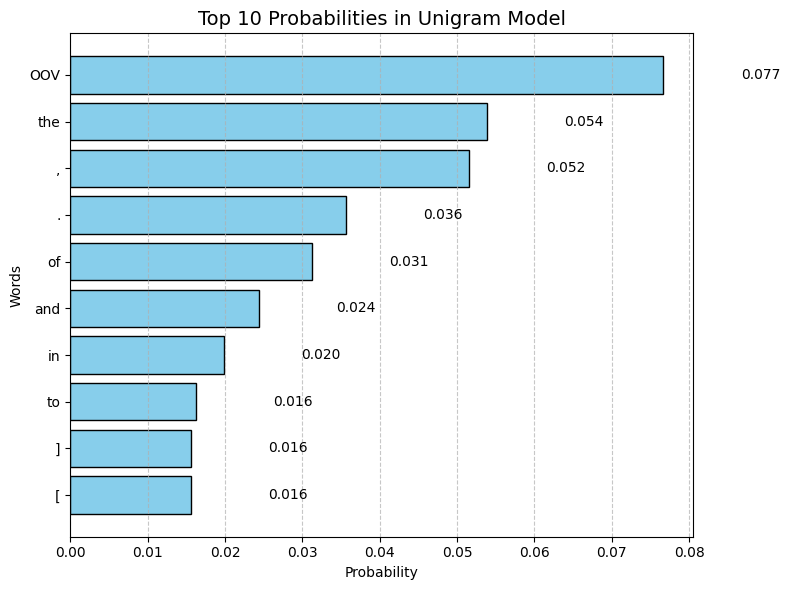

In [5]:
for lang in languages:
    doc_words_train = [item for items in train_set_dict[lang]['doc_text_words'] for item in items]
    doc_words_test = [item for items in val_set_dict[lang]['doc_text_words'] for item in items]
    print(f"Unigram for {language}:")
    unigram_model, oov_vocab, perplexity_uniform, perplexity_unigram = unigram_injection(doc_words_train, doc_words_test)
    print(f"Uniform Model Perplexity: {round(perplexity_uniform, 3)}")
    print(f"Unigram Model Perplexity: {round(perplexity_unigram, 3)}")
    plot_top_probabilities(unigram_model, oov_vocab, model_name="Unigram Model", amount=10)

# The bigram model

In [6]:
def bigram_interpolated(train, test, language, alpha_range=np.arange(0, 1.1, 0.1)):
    """
    Train and evaluate a bigram interpolated language model with OOV handling.

    Args:
        train: Training data as a list of tokens.
        test: Test data as a list of tokens.
        language: Name of the language (for logging).
        alpha_range: Range of alpha values to evaluate interpolation.

    Returns:
        None
    """
    # Prepare training and test data with OOV handling
    oov_train = inject_OOVs(train)
    oov_vocab = set(oov_train)
    oov_test =  [word if word in oov_vocab else 'OOV' for word in test]

    # Train models
    unigram = NGramLM(oov_train, 1)
    bigram = NGramLM(oov_train, 2)
    adjusted_laplace_bigram = AdjustedLaplaceLM(bigram, alpha=0.01)
    interpolatedLM = InterpolatedLM(adjusted_laplace_bigram, unigram, alpha=0.01)

    # Evaluate perplexities for different alpha values
    perplexities = [
        InterpolatedLM(adjusted_laplace_bigram, unigram, alpha).perplexity(oov_test)
        for alpha in alpha_range
    ]
    min_perplexity = min(perplexities)
    min_alpha = alpha_range[perplexities.index(min_perplexity)]
    interpolatedLM = InterpolatedLM(adjusted_laplace_bigram, unigram, min_alpha)

    # Sum of probabilities
    total_probability = interpolatedLM.sum_probabilities()

    # Print results
    print(f"Bigram Interpolated for {language}:")
    print(f"Sum of Probabilities: {round(total_probability, 2)}")
    print(f"Minimum Perplexity: {round(min_perplexity, 2)}")
    print(f"Corresponding Alpha: {round(min_alpha, 2)}")
    unigram_perplexity = unigram.perplexity(oov_test)
    bigram_perplexity = adjusted_laplace_bigram.perplexity(oov_test)
    print(f"Unigram Perplexity: {unigram_perplexity}")
    print(f"Bigram Perplexity: {bigram_perplexity}")

    # Plot perplexity vs alpha
    plt.figure(figsize=(8, 6))
    plt.plot(alpha_range, perplexities, marker='o', label='Perplexity Curve')
    plt.scatter(min_alpha, min_perplexity, color='red', label=f"Min: ({round(min_alpha, 2)}, {round(min_perplexity, 2)})")
    plt.xlabel("Alpha")
    plt.ylabel("Perplexity")
    plt.title(f"Perplexity vs Alpha for Bigram Interpolated Model ({language})")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

Bigram Interpolated for English:
Sum of Probabilities: 1.0
Minimum Perplexity: 551.89
Corresponding Alpha: 1.0
Unigram Perplexity: 719.9212514936822
Bigram Perplexity: 551.8934555149241


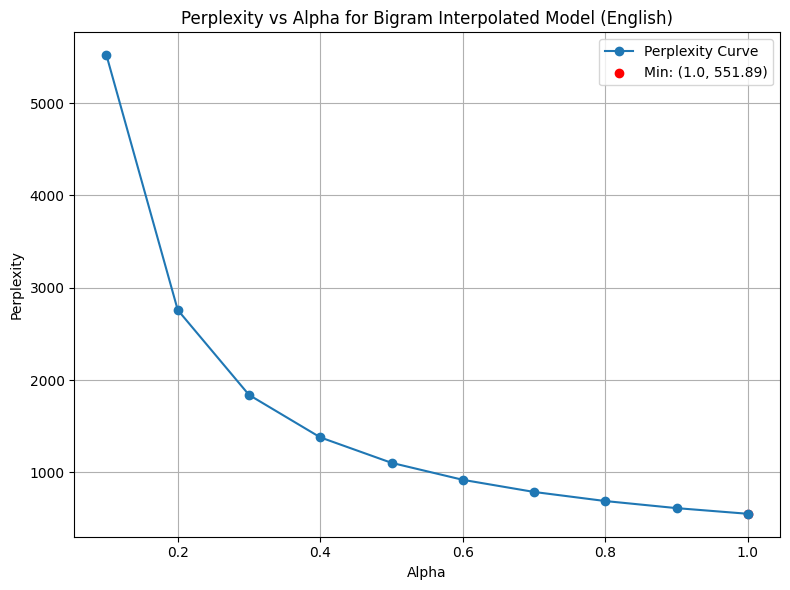

In [7]:
doc_words_eng_train = [item for items in train_set_dict['english']['doc_text_words'] for item in items]
doc_words_eng_test = [item for items in val_set_dict['english']['doc_text_words'] for item in items]

bigram_interpolated(doc_words_eng_train, doc_words_eng_test, "English")


Bigram Interpolated for English:
Sum of Probabilities: 1.0
Minimum Perplexity: 49.95
Corresponding Alpha: 1.0
Unigram Perplexity: 133.9811364516475
Bigram Perplexity: 49.94576739164424


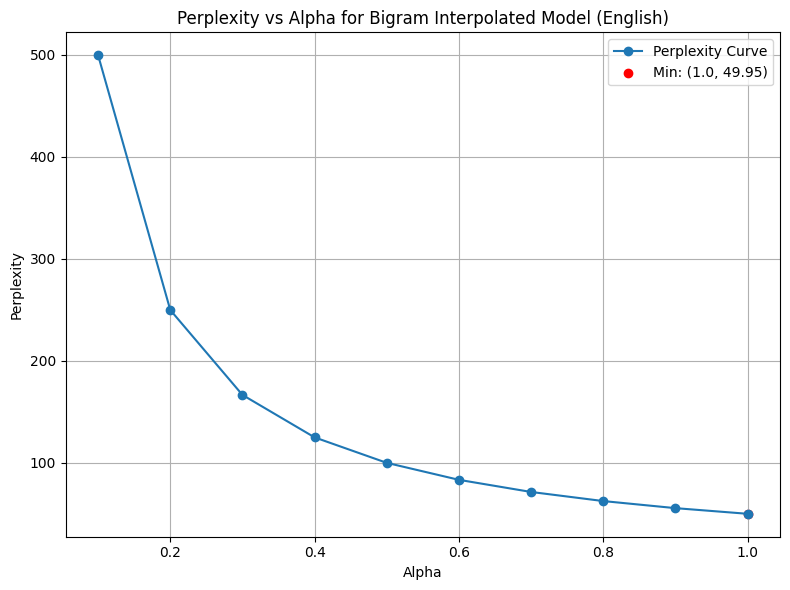

In [8]:
q_words_eng_train = [item for items in train_set_dict['english']['question_words'] for item in items]
q_words_eng_test = [item for items in val_set_dict['english']['question_words'] for item in items]

bigram_interpolated(q_words_eng_train, q_words_eng_test, "English")
